<a href="https://colab.research.google.com/github/dariashcherbakovaaa/MA_DSE_Unimi/blob/network_science/SNA_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "dariashcherbakovaa"
os.environ['KAGGLE_KEY'] = "b548e6d99396ffac6cb1a36b2cdb29fb"
!kaggle datasets download -d thedevastator/relato-business-network-graph-373663-domain-conn
!unzip relato-business-network-graph-373663-domain-conn.zip -d data

relato-business-network-graph-373663-domain-conn.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  relato-business-network-graph-373663-domain-conn.zip
replace data/companies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log
from collections import Counter, defaultdict
import scipy.stats
from scipy.stats import poisson, powerlaw

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, precision_recall_curve, auc, classification_report

import networkx as nx

# Read data & preprocess

In [11]:
links = pd.read_csv('/content/data/links.csv')

<ipython-input-11-d97df1c187af>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  links = pd.read_csv('/content/data/links.csv')


In [12]:
links = links[['home_name', 'link_name', 'type']]
links.shape

(373663, 3)

In [13]:
links = links.dropna()
links.shape

(373311, 3)

In [14]:
links = links.drop_duplicates()
links.shape

(373239, 3)

In [15]:
links['type'].value_counts()

partnership    112675
customer        80452
supplier        79389
investment      71630
competitor      29093
Name: type, dtype: int64

In [16]:
competitors = links[links['type'] == 'competitor']
competitors.shape

(29093, 3)

In [17]:
customers = links[links['type'] == 'customer']
customers.shape

(80452, 3)

In [18]:
collabs = links[links['type'] == 'partnership']
collabs.shape

(112675, 3)

# Competitor data

In [ ]:
competitors['home_name'].nunique()

7129

In [ ]:
competitors['link_name'].nunique()

6474

In [ ]:
competitors['home_name'].value_counts()[:10]

Microsoft          246
IBM                225
Google             222
Facebook           216
SAP                163
Apple Inc.         145
Oracle             142
Amazon             123
Hewlett-Packard    110
Cisco              108
Name: home_name, dtype: int64

In [ ]:
competitors['home_name'].value_counts()[::-1][:10]

Helium          1
Corbis          1
GreenPoint      1
FleetMatics     1
CBR             1
Greggs          1
Greif           1
Cordis          1
Fleetwood RV    1
Oxmoor House    1
Name: home_name, dtype: int64

In [ ]:
competitors['link_name'].value_counts()[:10]

Google             319
Apple Inc.         232
Microsoft          211
Facebook           205
Amazon             202
Sony               130
IBM                124
Walmart            122
Samsung            111
Hewlett-Packard     97
Name: link_name, dtype: int64

In [ ]:
competitors['link_name'].value_counts()[::-1][:10]

Nagios                   1
Ambac Financial Group    1
Winston & Strawn         1
KNIME                    1
Kemin Industries         1
Targus                   1
Kroll                    1
Phillips Petroleum       1
Thermador                1
Armada                   1
Name: link_name, dtype: int64

# Competitors (whole network)

In [ ]:
G = nx.Graph()
G =nx.from_pandas_edgelist(competitors, 'home_name', 'link_name')
print(G)

Graph with 8596 nodes and 23654 edges


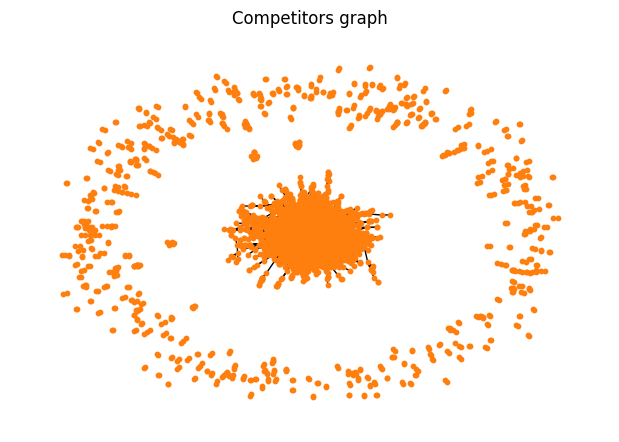

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:orange", pos=nx.spring_layout(G))
plt.title("Competitors graph")
plt.show()

In [ ]:
counts_home = competitors.groupby('home_name').size()
counts_link = competitors.groupby('link_name').size()

selected_companies_home = counts_home[counts_home >= 10].index
selected_companies_link = counts_link[counts_link >= 10].index

sample_company = competitors[
    competitors['home_name'].isin(selected_companies_home) & competitors['link_name'].isin(selected_companies_link)
    ]
print(sample_company['home_name'].value_counts())

Google                        126
Microsoft                     121
Facebook                      109
IBM                           103
SAP                            81
                             ... 
Sitecore                        1
Fusion                          1
Horlicks                        1
Rally Software Development      1
SpringCM's                      1
Name: home_name, Length: 546, dtype: int64


In [ ]:
G = nx.Graph()
G =nx.from_pandas_edgelist(sample_company, 'home_name', 'link_name')
print(G)

Graph with 859 nodes and 5807 edges


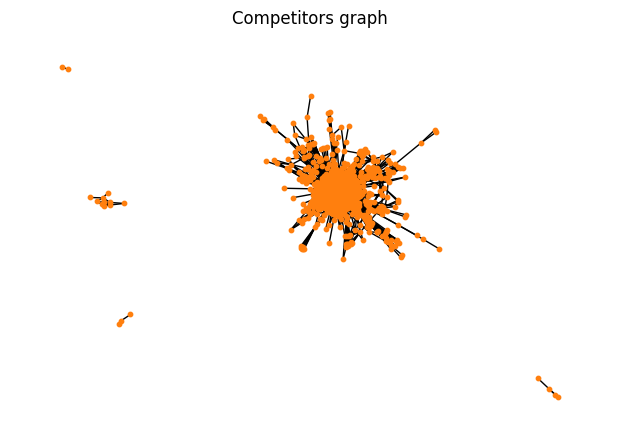

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:orange", pos=nx.spring_layout(G))
plt.title("Competitors graph")
plt.show()

## Network EDA

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

Number of nodes: 859
Number of edges: 5807

The density of the network: 0.0158


In [ ]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Avg.degree: 13.520372526193247 

Min degree: 1 

Max degree: 203 

Standard Deviation: 17.959351123020667 

Median: 9.0


In [ ]:
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

Number of connetced components in the network: 5


In [ ]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Random nodes: 859 
Random edges: 5904
Number of connetced components in the network: 1
Avg.degree: 13.746216530849825 

Min degree: 3 

Max degree: 27 

Standard Deviation: 3.509288390850411 

Median: 14.0


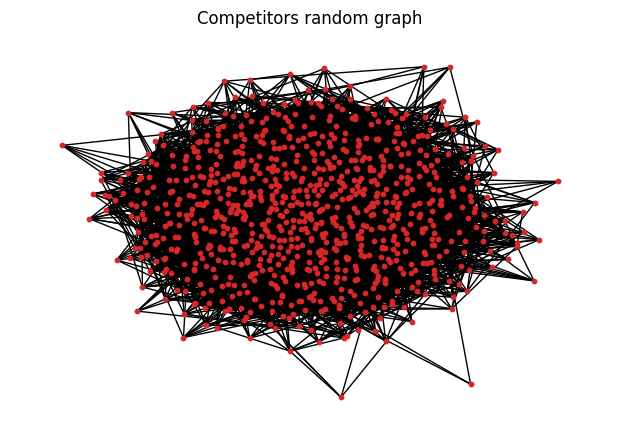

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="tab:red", pos=nx.spring_layout(rn))
plt.title("Competitors random graph")
plt.show()

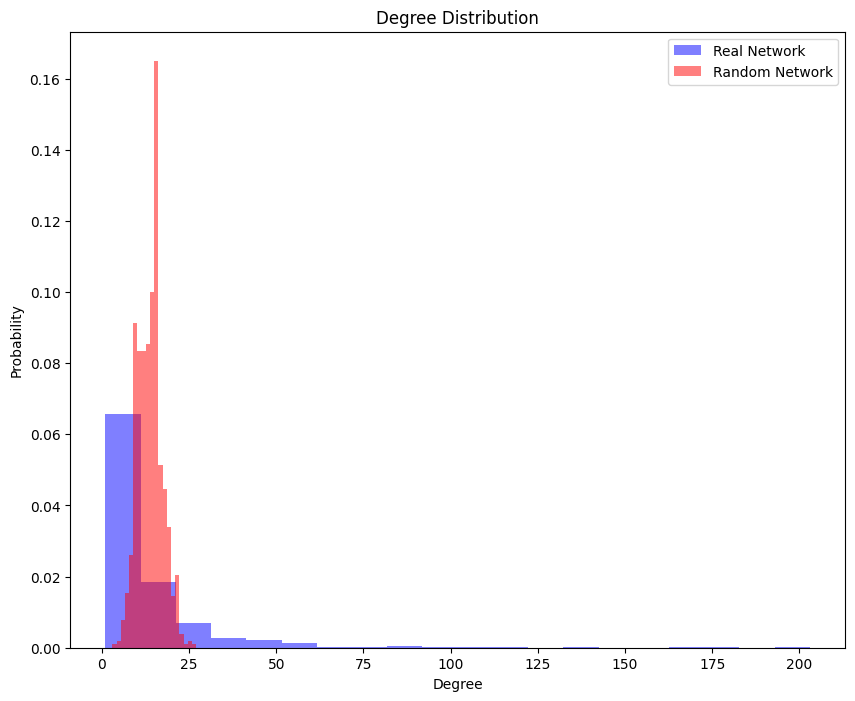

In [ ]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(10, 8))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

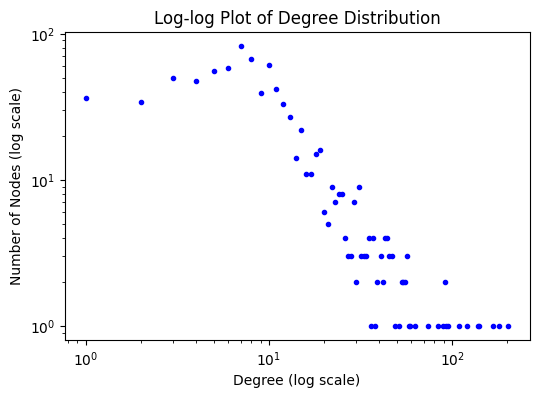

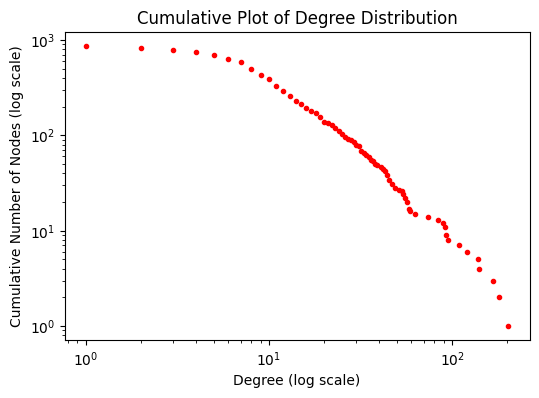

In [ ]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [ ]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central)

Most central nodes according to the following definitions: 	

Degree: Google 	

Closeness Google 	

Betweenness Google 	

Eigenvector Google


In [ ]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eigen_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eigen_centrality.keys())[:5]

print(
    "Top 10 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw,
    "\nEigenvector:", top_eigen
)

Top 10 nodes according to:	
Degree centrality: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Closeness: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Betweness: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Eigenvector: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM']


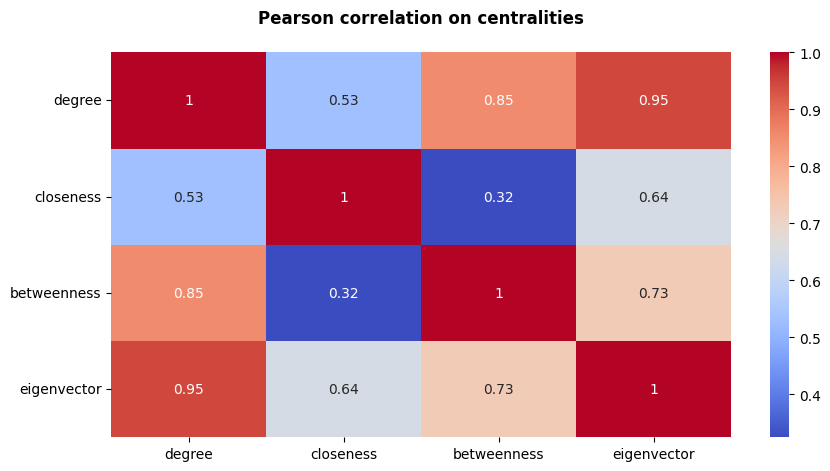

In [ ]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality,eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [ ]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

The graph is not connected
Number of connetced components in the network: 5


In [ ]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

diam_lcc = nx.diameter(lcc)
print(diam_lcc)

840
5783
3.140938759293944
9


In [ ]:
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

components_count

defaultdict(int, {840: 1, 4: 1, 10: 1, 2: 1, 3: 1})

In [ ]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
38
0.006543826416394007


In [ ]:
def count_local_and_global_bridges(G):
    local_bridges = 0
    global_bridges = 0

    for edge in G.edges():
        temp_G = G.copy()
        temp_G.remove_edge(*edge)


        if nx.is_connected(temp_G):

            u, v = edge
            if not nx.has_path(temp_G, u, v):
                local_bridges += 1
        else:
            global_bridges += 1

    return local_bridges, global_bridges

local_bridges, global_bridges = count_local_and_global_bridges(G)
print("Local Bridges:", local_bridges)
print("Global Bridges:", global_bridges)

Local Bridges: 0
Global Bridges: 5813


In [ ]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-0.027732774679885587


In [ ]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.1545333181844004 
Average local clustering coefficient: 0.313865408122082


In [ ]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")

Network Modularity (Greedy algorithm): 0.367
Number of partitions (communities) obtained by Greedy algorithm: 20
Size of each partition: [260, 239, 69, 58, 47, 28, 26, 25, 18, 18, 17, 13, 10, 10, 6, 4, 4, 3, 2, 2]


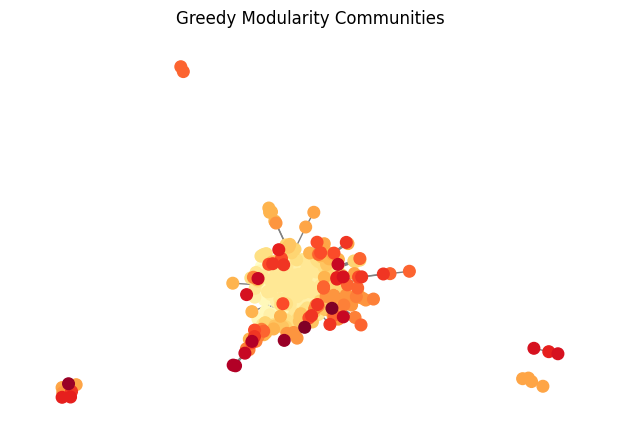

In [ ]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, node_size=70, cmap=plt.cm.YlOrRd, node_color=colors, edge_color='gray')
plt.title('Greedy Modularity Communities')
plt.show()

In [ ]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")

Network Modularity: 0.390
Number of communities obtained by Louvain algorithm: 23


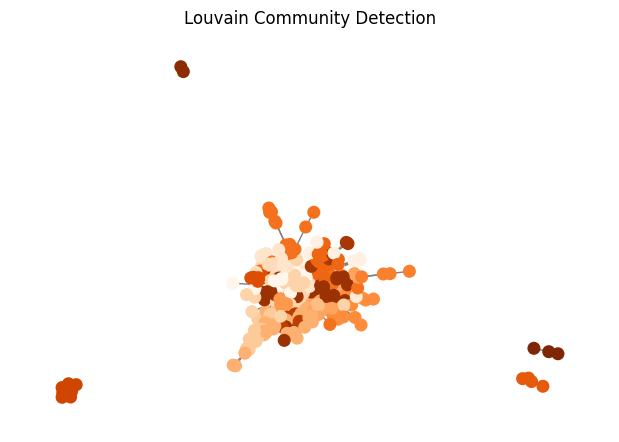

In [ ]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=70, node_color=node_colors, cmap=plt.cm.Oranges, edge_color='gray')
plt.title('Louvain Community Detection')
plt.show()

## ML part

Link prediction

In [ ]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

5807

In [ ]:
negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1

In [ ]:
dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('Samsung', 'Garmin'),
 ('Samsung', 'A10 Networks'),
 ('Samsung', 'Apple Inc.'),
 ('Samsung', 'Google'),
 ('Samsung', 'Intel'),
 ('Samsung', 'Dell'),
 ('Samsung', 'Qualcomm'),
 ('Samsung', 'Hewlett-Packard'),
 ('Samsung', 'Southwest Airlines'),
 ('Samsung', 'Bloomberg')]

In [ ]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
11266,0.055556,0.005556,0.192569,84,0,Qik,Procter & Gamble
5459,0.357143,0.354004,1.882313,90,1,Neotys,Smart Bear
6890,0.000000,0.000000,0.000000,30,0,Jive Software,Cornell
6599,0.000000,0.000000,0.000000,28,0,Gogo,Weber Shandwick
1163,0.000000,0.000000,0.000000,116,1,EMC,Aria Systems
2751,0.051724,0.053887,0.717876,510,1,Walmart,VUDU
9811,0.073171,0.076708,0.793523,448,0,Hulu,Plaxo
6406,0.000000,0.000000,0.000000,80,0,Spotify,Aflac


In [ ]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

In [ ]:
X.shape, y.shape

((11614, 6), (11614,))

In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

((8710, 6), (8710,))

In [ ]:
X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((8710, 4), (2904, 4))

In [ ]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 79.99%


In [ ]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1410
           1       0.88      0.70      0.78      1494

    accuracy                           0.80      2904
   macro avg       0.81      0.80      0.80      2904
weighted avg       0.81      0.80      0.80      2904



*- из всех объектов, которые модель предсказала как класс 0, 76% действительно принадлежат к классу 0, и 89% всех объектов класса 0 были правильно предсказаны моделью*

*- из всех объектов, которые модель предсказала как класс 1, 91% действительно принадлежат к классу 1, и 72% всех объектов класса 1 были правильно предсказаны моделью.*

In [ ]:
link_predictor['classifier'].coef_

array([[ 8.61110567, 16.56460486,  9.5483733 , 81.87404904]])

In [ ]:
coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

              home               customer
6315         Intel              inContact
7811  Aria Systems  Celedon Partners, LLC
8015    Centro dsp               Fortinet
3660           SAP      Johnson & Johnson
1971      T-Mobile                  Icahn
7103          Bose                    HBO
1766         Volvo                 Amtrak
7413        Nexsan                 Altera
6422  Ticketmaster                  Wrike
9232          Saab                  Vizio


In [ ]:
print(connected_pairs.sample(10))

                                home                           customer
9915                       Starbucks                       MetricStream
10916  Sungard Availability Services                           Maserati
5289              Hofstra University  Washington State University (WSU)
1516                           Intel                                 LG
11213                            H&M                           Citibank
3616                   Credit Suisse                             NetApp
2102                        LinkedIn                             Flickr
5545                        Parasoft                          Froglogic
7225                            Zain                           Internap
1593                             AMD                           Acer Inc


Clustering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Assuming X contains your numerical features
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref']]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Print cluster labels
print(clusters)


[ 0  0 -1 ...  0  0  0]


In [ ]:
num_clusters = len(np.unique(clusters))
print("Количество кластеров:", num_clusters)

Количество кластеров: 3


In [ ]:
num_outliers = np.sum(clusters == -1)
print("Количество выбросов:", num_outliers)

Количество выбросов: 150


In [ ]:
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        continue  # Пропускаем выбросы
    cluster_points = X[clusters == cluster_id]  # Выбираем точки, принадлежащие текущему кластеру
    cluster_mean = np.mean(cluster_points, axis=0)  # Вычисляем среднее значение признаков для кластера
    print(f"Средние значения для кластера {cluster_id}: {cluster_mean}")

Средние значения для кластера 0: jaccard      0.059050
rai          0.101670
aai          0.771973
pref       629.442204
dtype: float64
Средние значения для кластера 1: jaccard        0.165263
rai            1.205363
aai            9.911896
pref       11111.300000
dtype: float64


In [ ]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00


In [ ]:
present_link = list(G.edges())
present_link = [(u, v) for u, v in present_link]

absent_link = []
nodes_set = list(G.nodes())
k = 0
while k < len(present_link):
  u , v = np.random.choice(nodes_set, size = 2, replace = True)
  if (not G.has_edge(u, v) and not G.has_edge(v , u)):
    absent_link.append((u,v))
    k +=1

dataset = pd.DataFrame()
all_links = present_link + absent_link

dataset['company'] = [u for u, _ in all_links]
dataset['competitor'] = [v for _, v in all_links]
dataset['label'] = [1 for _ in range(len(present_link))] + [0 for _ in range(len(absent_link))]

dataset

,company,competitor,label
0,Samsung,Garmin,1
1,Samsung,A10 Networks,1
2,Samsung,Apple Inc.,1
3,Samsung,Google,1
4,Samsung,Intel,1
...,...,...,...
11609,CBR Technology Corp.,Qualys,0
11610,NTT Communications,Southern New Hampshire University,0
11611,AT&T,General Dynamics,0
11612,Avaya,SpringCM's,0


In [ ]:
!pip install dgl
! pip install node2vec

import pandas as pd
import dgl
from node2vec import Node2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
src_ids = label_encoder.fit_transform(src)
dst_ids = label_encoder.fit_transform(dst)

graph = dgl.graph((src_ids, dst_ids))

In [ ]:
node2vec = Node2Vec(graph.to_networkx(), dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = model.wv

Computing transition probabilities:   0%|          | 0/8548 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

In [ ]:
model = GCN(in_feats=64, hidden_size=32, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
model.train()
optimizer.zero_grad()
logits = model(graph, X_train)
loss = F.cross_entropy(logits, y_train)
loss.backward()
optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(graph, X_test)

# Customer data

In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist(customers, 'home_name', 'link_name')
print(G)

Graph with 19653 nodes and 77601 edges


In [57]:
customer_count = customers.groupby('home_name').size()
selected_home_companies = customer_count[customer_count >= 9].index & customer_count[customer_count <= 15].index
sampled_customer = customers[customers['home_name'].isin(selected_home_companies)]

sampled_customer

<ipython-input-57-ad6a91b52f61>:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  selected_home_companies = customer_count[customer_count >= 9].index & customer_count[customer_count <= 15].index


,home_name,link_name,type
23426,Big Data & Analytics For Financial Services,Process Excellence Network,customer
23427,Big Data & Analytics For Financial Services,Amazon Web Services,customer
23428,Big Data & Analytics For Financial Services,Intel,customer
23429,Big Data & Analytics For Financial Services,Splunk,customer
23430,Big Data & Analytics For Financial Services,Smarsh,customer
...,...,...,...
360388,Publicus Groupe,Bristol-Myers Squibb,customer
360389,Publicus Groupe,Carrefour,customer
360390,Publicus Groupe,Citigroup,customer
360391,Publicus Groupe,The Coca-Cola Company,customer


In [58]:
G = nx.Graph()
G =nx.from_pandas_edgelist(sampled_customer, 'home_name', 'link_name')
print(G)

Graph with 3762 nodes and 7600 edges


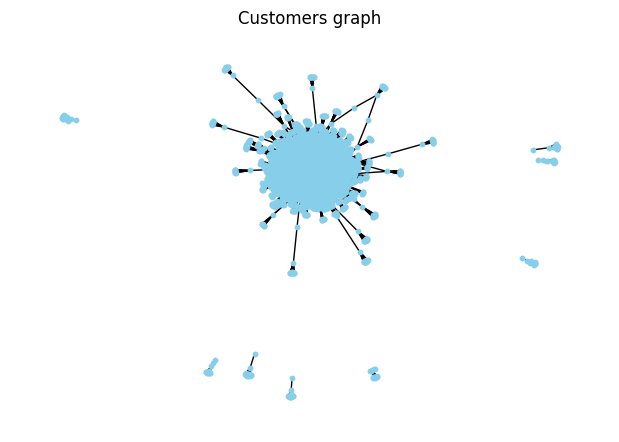

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="skyblue", pos=nx.spring_layout(G))
plt.title("Customers graph")
plt.show()

### EDA

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

Number of nodes: 3762
Number of edges: 7600

The density of the network: 0.0011


In [ ]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Avg.degree: 4.040404040404041 

Min degree: 1 

Max degree: 113 

Standard Deviation: 6.215555989093085 

Median: 1.0


In [ ]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Random nodes: 3762 
Random edges: 7635
Number of connetced components in the network: 71
Avg.degree: 4.059011164274322 

Min degree: 0 

Max degree: 12 

Standard Deviation: 2.026466266529236 

Median: 4.0


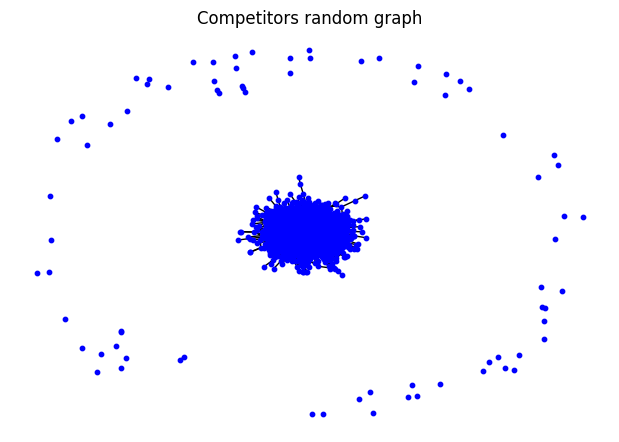

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="blue", pos=nx.spring_layout(rn))
plt.title("Competitors random graph")
plt.show()

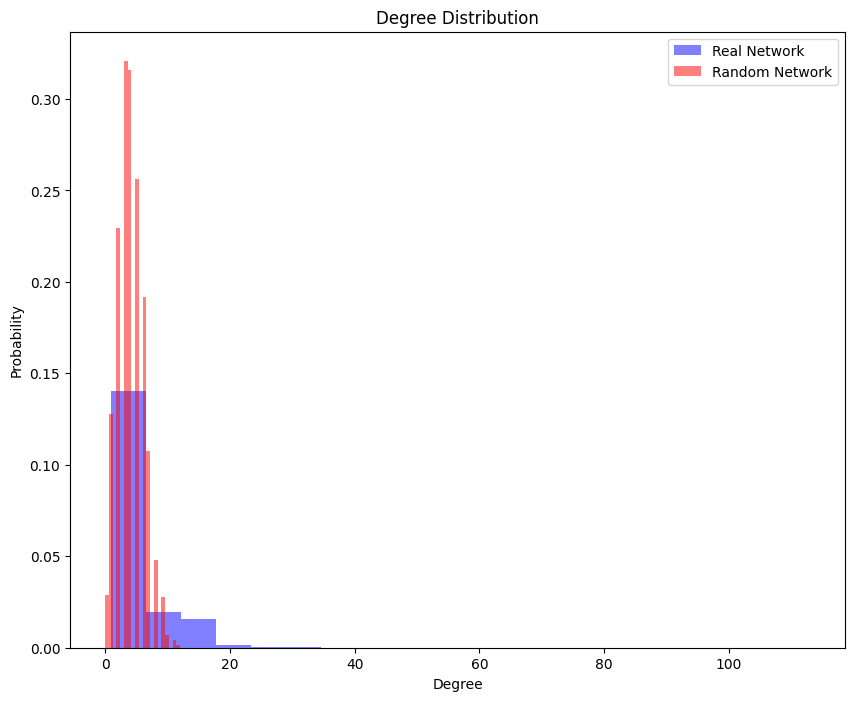

In [ ]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(10, 8))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

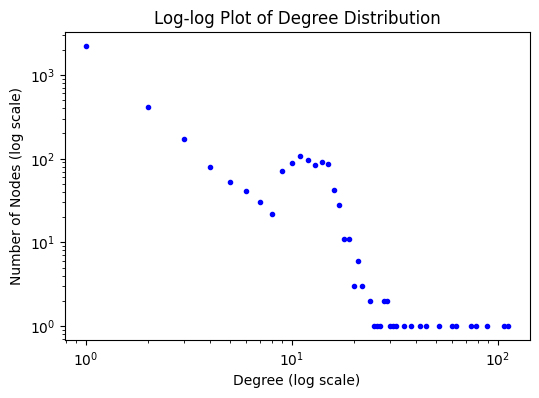

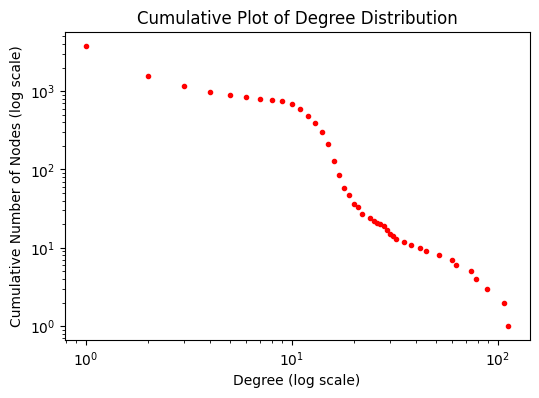

In [ ]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [ ]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central)

Most central nodes according to the following definitions: 	

Degree: Microsoft 	

Closeness Microsoft 	

Betweenness Microsoft 	

Eigenvector Microsoft


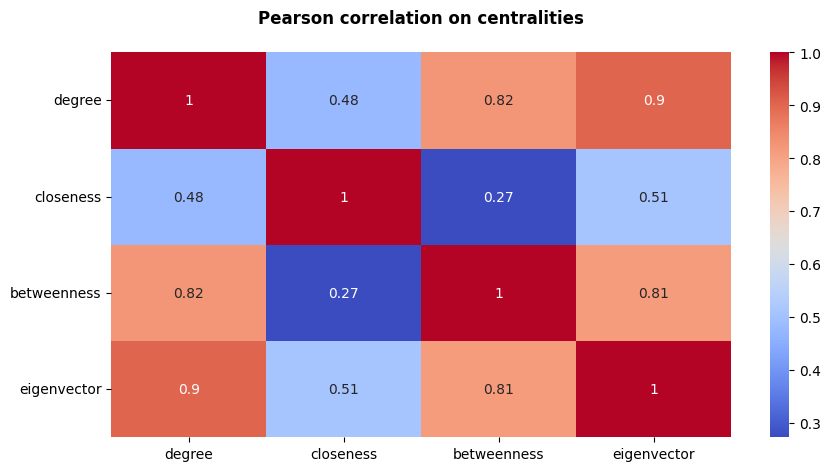

In [ ]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality,eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [ ]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eigen_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eigen_centrality.keys())[:5]

print(
    "Top 5 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw,
    "\nEigenvector:", top_eigen
)

In [ ]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

The graph is not connected
Number of connetced components in the network: 9


In [ ]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

# diam_lcc = nx.diameter(lcc)
# print(diam_lcc)

3658
7504
4.7280358242534035


In [ ]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
2211
0.29092105263157897


In [ ]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-9.310095756061908e-05


In [ ]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.006922402271967925 
Average local clustering coefficient: 0.004911535277319694


Network Modularity (Greedy algorithm): 0.534
Number of partitions (communities) obtained by Greedy algorithm: 42
Size of each partition: [509, 468, 231, 155, 147, 142, 140, 133, 131, 128, 126, 111, 110, 97, 94, 94, 78, 77, 69, 69, 60, 56, 55, 54, 51, 50, 46, 42, 40, 39, 26, 16, 16, 14, 13, 13, 13, 11, 11, 10, 10, 7]


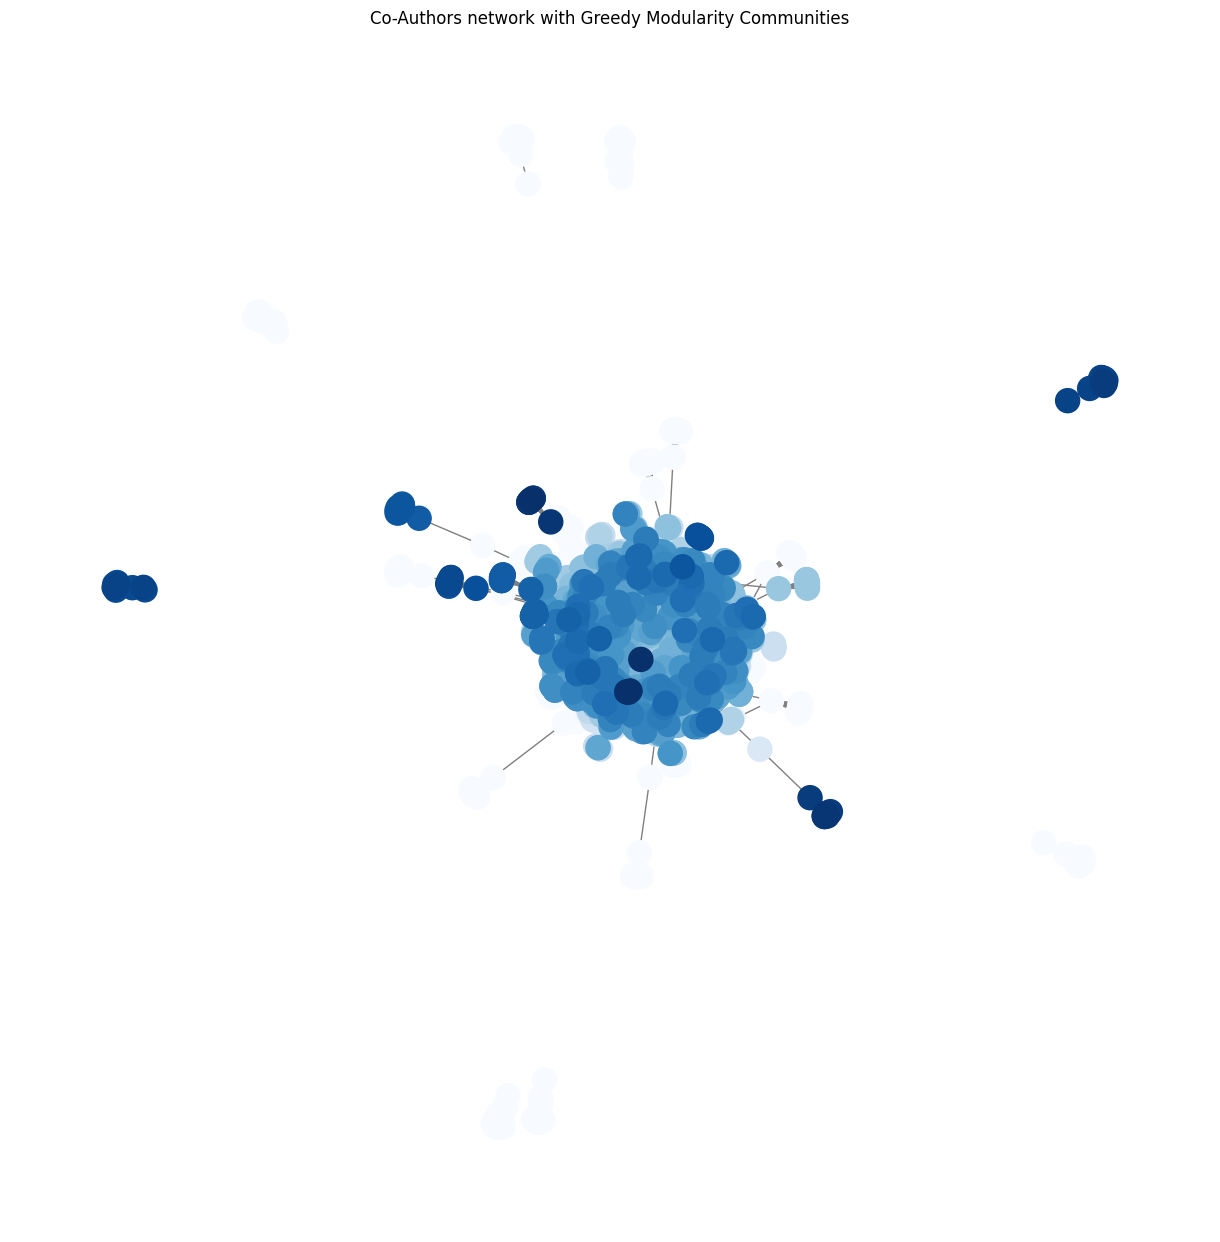

In [ ]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")


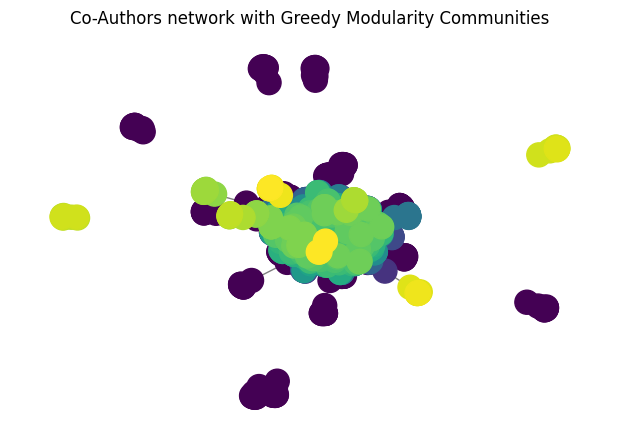

In [ ]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, cmap=plt.cm.viridis, node_color=colors, font_size=8, font_color="black", font_weight="bold", edge_color='gray')
plt.title('Co-Authors network with Greedy Modularity Communities')
plt.show()

Network Modularity: 0.537
Number of communities obtained by Louvain algorithm: 40


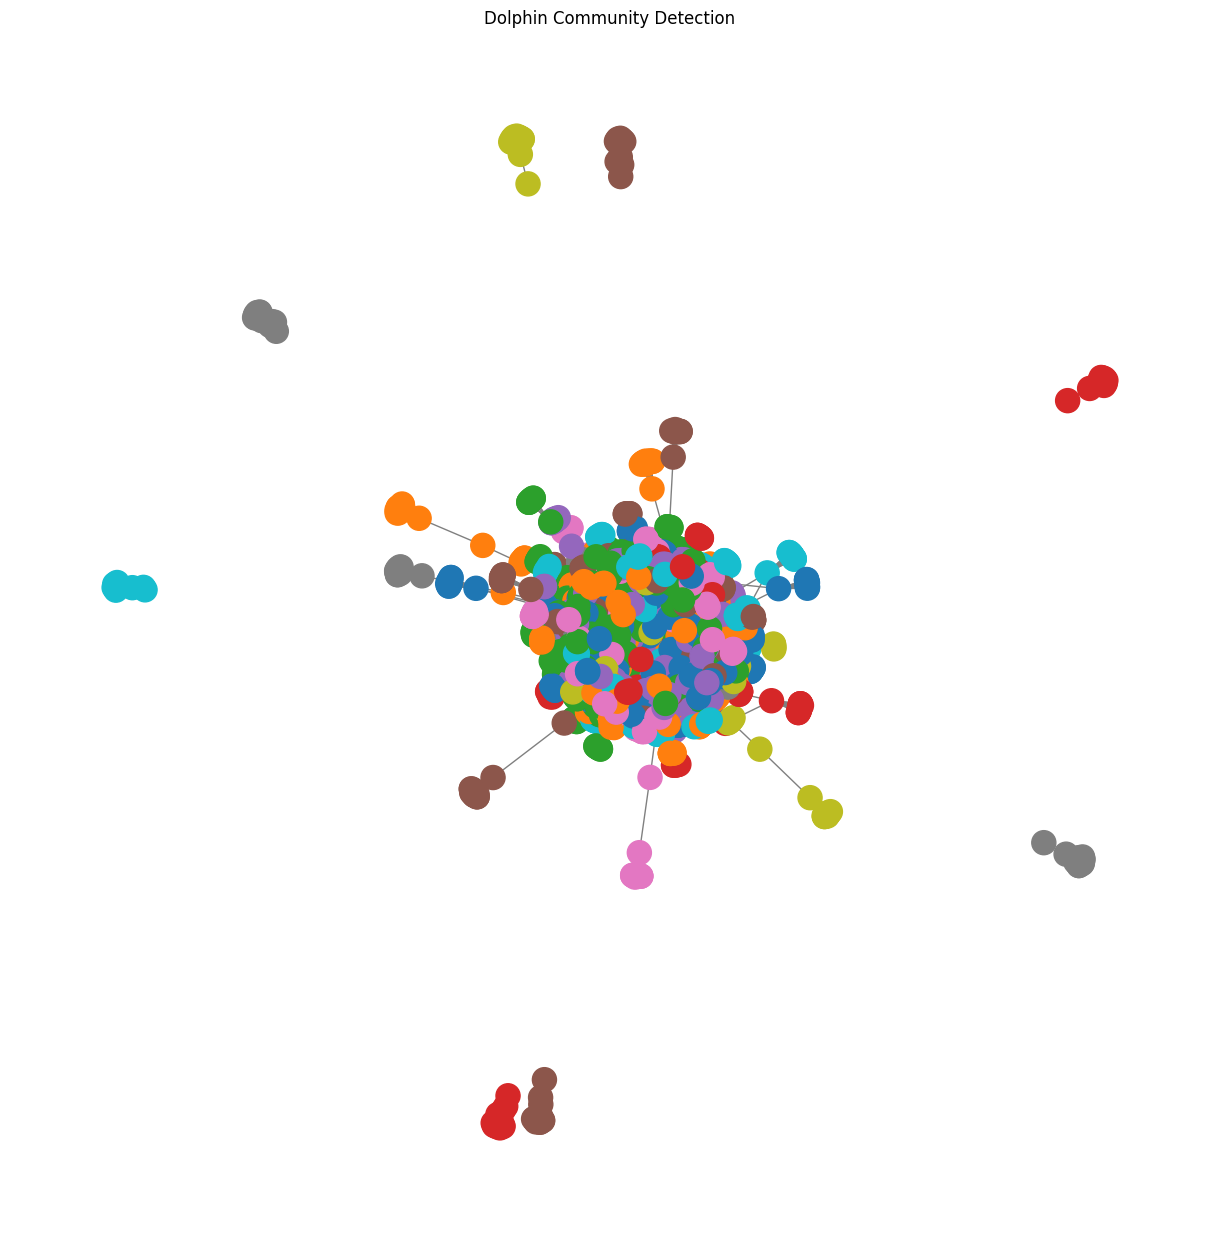

In [ ]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")


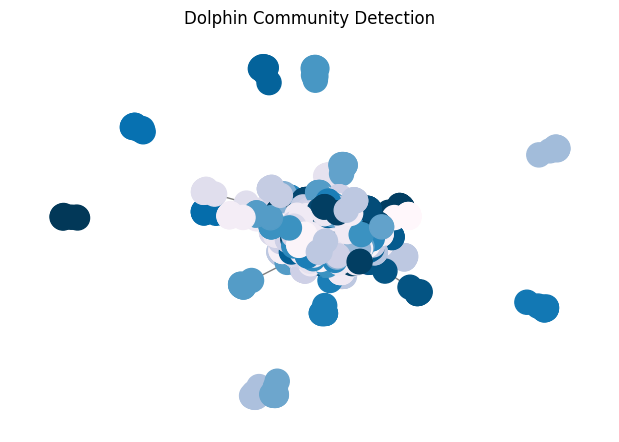

In [ ]:

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.PuBu, font_size=8, font_color="black", font_weight="bold", edge_color='gray')
plt.title('Dolphin Community Detection')
plt.show()

### ML

In [ ]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

7600

In [ ]:
negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1

In [ ]:
dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('Big Data & Analytics For Financial Services', 'Process Excellence Network'),
 ('Big Data & Analytics For Financial Services', 'Amazon Web Services'),
 ('Big Data & Analytics For Financial Services', 'Intel'),
 ('Big Data & Analytics For Financial Services', 'Splunk'),
 ('Big Data & Analytics For Financial Services', 'Smarsh'),
 ('Big Data & Analytics For Financial Services', 'EY'),
 ('Big Data & Analytics For Financial Services', 'OpenText'),
 ('Big Data & Analytics For Financial Services', 'Corvil'),
 ('Big Data & Analytics For Financial Services', 'Angoss'),
 ('Intel', 'Abengoa')]

In [ ]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
11362,0.000000,0.000000,0.000000,1,0,Sky Sports,Saxo Bank
5296,0.000000,0.000000,0.000000,12,1,Aviat Networks,PKF
13405,0.000000,0.000000,0.000000,21,0,Doctors Hospital of Sarasota (Florida),STMicroelectronics
3632,0.038462,0.071429,0.378923,182,1,Sports Illustrated,Panasonic
11801,0.000000,0.000000,0.000000,2,0,Exterran,Schneider Electric
3932,0.000000,0.000000,0.000000,51,1,Merge Healthcare,Altru Health System
3355,0.000000,0.000000,0.000000,22,1,Agrium,Manulife Financial
1097,0.000000,0.000000,0.000000,26,1,Finisar,Guidance


In [ ]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((11400, 4), (3800, 4))

In [ ]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 74.89%


In [ ]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1910
           1       0.87      0.58      0.70      1890

    accuracy                           0.75      3800
   macro avg       0.78      0.75      0.74      3800
weighted avg       0.78      0.75      0.74      3800



In [ ]:
print(link_predictor['classifier'].coef_)

coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

[[ -0.62458993  18.69575168 -15.28765316  60.81105576]]
                       home                     customer
3165                 InMobi                         IDEO
3691               Citibank                      Xiotech
3297               Symantec                       Vitria
10409                   BPA                     ViryaNet
7934   Laboratory Equipment  City University of New York
3488                 Flickr                         Cyan
7050                  Cvent                 PriceGrabber
1310                MariaDB             VERKKOKAUPPA.COM
8724                 Corbus           Rio Tinto Minerals
8192          Red Roof Inns                     Pegatron


In [ ]:
connected_pairs.sample(10)

,home,customer
9527,MetLife,StockTwits
1768,LG,Imagination
1327,"Ooyala, Inc",Vice
14270,Central European Distribution,Fred Meyer
474,Total S.A.,Parametric Technology
1024,SOASTA,BMW
1421,Neolane,Xradia
10765,Broadcom,CloudFlare
12522,GoPro,IEC Electronics
12181,docSTAR,Par Pharmaceutical Companies


In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=2,q=1,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(cust):
  companies = []

  for company in model.wv.most_similar(str(cust))[:5]:
    companies.append(company)

  print(companies)

rec("LG")
rec("Google")
rec('Microsoft')
rec('IBM')

Computing transition probabilities:   0%|          | 0/3762 [00:00<?, ?it/s]

In [ ]:
node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=1,q=2,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(cust):
  companies = []

  for company in model.wv.most_similar(str(cust))[:5]:
    companies.append(company)

  print(companies)

rec("LG")
rec("Google")
rec('Microsoft')
rec('IBM')

bottom_degree = list(sort_degree_centrality.keys())[-5:]
for node in bottom_degree:
  rec(node)

# Collabs

In [21]:
G = nx.Graph()
G = nx.from_pandas_edgelist(collabs, 'home_name', 'link_name')
print(G)

Graph with 43065 nodes and 108831 edges


In [44]:
unique_home_companies = collabs['home_name'].unique()
random_selected_home_companies = np.random.choice(unique_home_companies, size=1000, replace=False)
sampled_partnership = collabs[(collabs['home_name'].isin(random_selected_home_companies)) & (collabs['link_name'].isin(random_selected_home_companies))
                                  ]
partnership_count = sampled_partnership.groupby('home_name').size()
selected_home_companies = partnership_count[partnership_count > 1].index
sampled_partnership = sampled_partnership[sampled_partnership['home_name'].isin(selected_home_companies)]

sampled_partnership

,home_name,link_name,type
0,F5 Networks,Dell,partnership
5,F5 Networks,Dimension Data,partnership
6,F5 Networks,Accuvant,partnership
581,Tata Consultancy Services,Google,partnership
805,Hortonworks,Teradata,partnership
...,...,...,...
278374,Plex,Mattel,partnership
278378,Plex,Facebook,partnership
278440,Google,Fidelity Investments,partnership
278595,WANdisco,Sainsbury,partnership


In [45]:
G = nx.Graph()
G = nx.from_pandas_edgelist(sampled_partnership, 'home_name', 'link_name')
print(G)

Graph with 382 nodes and 959 edges


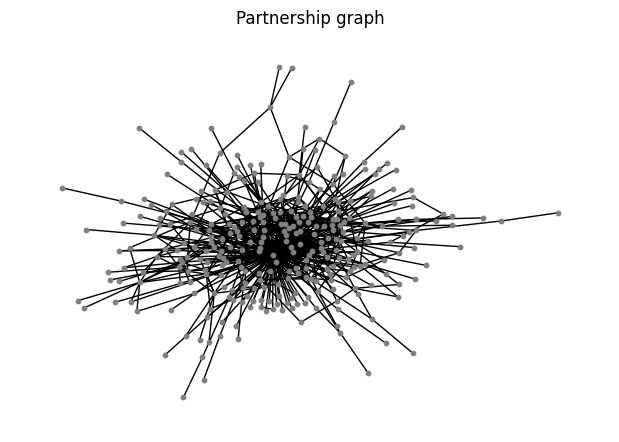

In [24]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:grey", pos=nx.spring_layout(G))
plt.title("Partnership graph")
plt.show()

### EDA

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

In [ ]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

In [ ]:
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

In [ ]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

In [ ]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="tab:red", pos=nx.spring_layout(rn))
plt.title("Partnership random graph")
plt.show()

In [ ]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(6, 4))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

In [ ]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [33]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central
      )

Most central nodes according to the following definitions: 	

Degree: Microsoft 	

Closeness Microsoft 	

Betweenness Microsoft 	

Eigenvector Microsoft


In [34]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eig_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eig_centrality.keys())[:5]

print(
    "Top 10 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw, top_eigen)

Top 10 nodes according to:	
Degree centrality: ['Microsoft', 'T-Mobile', 'Siemens', 'VMware', 'Boeing'] 
Closeness: ['Microsoft', 'T-Mobile', 'Siemens', 'Boeing', 'VMware'] 
Betweness: ['Microsoft', 'T-Mobile', 'Siemens', 'Deloitte', 'Boeing'] ['Microsoft', 'T-Mobile', 'Siemens', 'Boeing', 'VMware']


In [ ]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality, eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness', 'eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [ ]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

In [ ]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

diam_lcc = nx.diameter(lcc)
print(diam_lcc)

In [ ]:
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

components_count

In [ ]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

In [ ]:
def count_local_and_global_bridges(G):
    local_bridges = 0
    global_bridges = 0

    for edge in G.edges():
        temp_G = G.copy()
        temp_G.remove_edge(*edge)


        if nx.is_connected(temp_G):

            u, v = edge
            if not nx.has_path(temp_G, u, v):
                local_bridges += 1
        else:
            global_bridges += 1

    return local_bridges, global_bridges

local_bridges, global_bridges = count_local_and_global_bridges(G)
print("Local Bridges:", local_bridges)
print("Global Bridges:", global_bridges)

In [ ]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

In [ ]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

In [ ]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")

In [ ]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, node_size=70, cmap=plt.cm.YlOrRd, node_color=colors, edge_color='gray')
plt.title('Greedy Modularity Communities')
plt.show()

In [ ]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")

In [ ]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=70, node_color=node_colors, cmap=plt.cm.Oranges, edge_color='gray')
plt.title('Louvain Community Detection')
plt.show()

### ML

In [46]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1


dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('F5 Networks', 'Dell'),
 ('F5 Networks', 'Dimension Data'),
 ('F5 Networks', 'Accuvant'),
 ('F5 Networks', 'Aleron'),
 ('F5 Networks', 'Carahsoft'),
 ('F5 Networks', 'Big Switch Networks'),
 ('F5 Networks', 'Ahead'),
 ('F5 Networks', 'Lilien Systems'),
 ('F5 Networks', 'Scalar'),
 ('F5 Networks', 'FusionStorm')]

In [47]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
1542,0.000000,0.000000,0.000000,2,0,Commonwealth Bank of Australia,JMI Equity
897,0.000000,0.000000,0.000000,2,1,Marin Software Incorporated,IMI CORNELIUS
1916,0.000000,0.000000,0.000000,3,0,Goss,RapidMiner
804,0.045455,0.013699,0.233075,76,1,Pearson Education,Tata Communications
1551,0.000000,0.000000,0.000000,4,0,Telenor Group,AMA Pro Racing
805,0.000000,0.000000,0.000000,19,1,Pearson Education,Allstream
1740,0.000000,0.000000,0.000000,2,0,Bell Canada,JamBase
325,0.000000,0.000000,0.000000,4,1,Aleron,Venafi


In [48]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((1438, 4), (480, 4))

In [49]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 78.12%


In [50]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       229
           1       0.91      0.65      0.76       251

    accuracy                           0.78       480
   macro avg       0.81      0.79      0.78       480
weighted avg       0.81      0.78      0.78       480



In [51]:
print(link_predictor['classifier'].coef_)

coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

[[ -2.8474062  -12.16050663   2.99889034 246.01222079]]
                   home               customer
950   Fulton Innovation               Duracell
1468     Ball Aerospace       Smithfield Foods
609            Best Buy                    AIA
495            Facebook            CMSWire.com
1323        BitDefender        Young & Rubicam
1561              PDVSA           Orb Networks
1116           WANdisco            Bigcommerce
462            Facebook  Caesars Entertainment
1269           Reynolds         Star Analytics
674          Apple Inc.                Linksys


In [56]:
connected_pairs.sample(10)

,home,customer
1552,Sencha,BigPanda
411,Panasonic,Jetstar
1234,Okta,Compass Group
303,DataStax,USPS
32,Dell,Scalar
237,Google,Telenor Group
1054,Steelwedge,Anaqua
416,Panasonic,Shimano
1807,MBNA Canada Bank,Monster
609,Best Buy,AIA


# ML

In [40]:
# !pip install node2vec
from node2vec import Node2Vec

#p Parameter: Controls the likelihood of returning to the previous node in a random walk.
## A higher value biases the walk towards revisiting recent locations, promoting the exploitation of local structures.
# q Parameter: Governs the likelihood of moving away from the previous node.
## A lower value encourages exploration, allowing the walk to move towards nodes further away.

In [30]:
node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=2,q=1,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(collab):
  companies = []

  for company in model.wv.most_similar(str(collab))[:5]:
    companies.append(company)

  print(companies)

Computing transition probabilities:   0%|          | 0/308 [00:00<?, ?it/s]

[('Cypress Semiconductor', 0.7901104688644409), ('FCI', 0.5909750461578369), ('Banner Health', 0.543936550617218), ('LogLogic', 0.5224444270133972), ('Rittal', 0.48655250668525696)]


KeyError: "Key 'Deloitt' not present in vocabulary"

In [35]:
rec("Siemens")
rec("Microsoft")
rec("Boeing")

[('Cypress Semiconductor', 0.7901104688644409), ('FCI', 0.5909750461578369), ('Banner Health', 0.543936550617218), ('LogLogic', 0.5224444270133972), ('Rittal', 0.48655250668525696)]
[('Belk', 0.7667175531387329), ('Duracell', 0.7609708309173584), ('DreamFactory Software', 0.7555766105651855), ('Jade Global', 0.7526899576187134), ('American Water', 0.7502450942993164)]
[('Reliant Energy', 0.7899464964866638), ('SyCom', 0.7698091864585876), ('Entergy', 0.6209006309509277), ('LoJack', 0.5793379545211792), ('Rittal', 0.5376428961753845)]


In [36]:
bottom_degree = list(sort_degree_centrality.keys())[-5:]

In [38]:
for node in bottom_degree:
  rec(node)

[('TP-link', 0.9791022539138794), ('CarMax', 0.8941148519515991), ('Warner Bros', 0.8550496697425842), ('QVC', 0.8025840520858765), ('Kabam', 0.7972751259803772)]
[('Methanex', 0.9791021943092346), ('CarMax', 0.8875031471252441), ('Warner Bros', 0.8465524911880493), ('Kabam', 0.800261914730072), ('QVC', 0.790674090385437)]
[('JGC CORPORATION', 0.8826665282249451), ('Penguin Random House', 0.7064465880393982), ('Ciena Corporation', 0.6998609900474548), ('Cbeyond', 0.6937382817268372), ('BoomTown', 0.672889232635498)]
[('Kaiser Aluminum', 0.9768542051315308), ('Hitachi Consulting', 0.8818315863609314), ('LogLogic', 0.8528552055358887), ('Bank of New York Mellon Corp', 0.6559464931488037), ('Airbnb', 0.601611852645874)]
[('Act-On Software', 0.9800999164581299), ('Legacy Health', 0.8480755686759949), ('LinkedIn', 0.8348536491394043), ('Gigamon', 0.58253413438797), ('Prudential Financial', 0.5558678507804871)]


In [39]:
node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=1,q=2,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(collab):
  companies = []

  for company in model.wv.most_similar(str(collab))[:5]:
    companies.append(company)

  print(companies)

rec("Siemens")
rec("Microsoft")
rec("Boeing")

bottom_degree = list(sort_degree_centrality.keys())[-5:]
for node in bottom_degree:
  rec(node)

Computing transition probabilities:   0%|          | 0/308 [00:00<?, ?it/s]

[('Cypress Semiconductor', 0.8736538290977478), ('Banner Health', 0.6580809950828552), ('FCI', 0.6495558023452759), ('Rittal', 0.6169955730438232), ('LogLogic', 0.6107255220413208)]
[('Sanlam', 0.8339824080467224), ('TeamLogic IT of Mountain View', 0.8327491283416748), ('Laboratory Corporation of America', 0.8301530480384827), ('EXFO', 0.8224607706069946), ('MercadoLibre', 0.8211033344268799)]
[('SyCom', 0.8584356904029846), ('Reliant Energy', 0.8485991358757019), ('Entergy', 0.6776241064071655), ('LoJack', 0.6637766361236572), ('Rittal', 0.6011753678321838)]
[('TP-link', 0.9665727019309998), ('Warner Bros', 0.8842574954032898), ('CarMax', 0.8554668426513672), ('QVC', 0.7845124006271362), ('Kabam', 0.7719226479530334)]
[('Methanex', 0.966572642326355), ('CarMax', 0.8721535205841064), ('Warner Bros', 0.866332471370697), ('Kabam', 0.7774269580841064), ('QVC', 0.75821852684021)]
[('JGC CORPORATION', 0.9178203344345093), ('Ciena Corporation', 0.684763491153717), ('Intergraph', 0.6802467703